# CNN Netz zum Klassifiziern 

In [8]:
from read_and_label_Images import read_and_label_Images
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(2019)

### Daten laden und bereinigen

In [5]:
old_path='mvtec_anomaly_detection/'
new_path='bereinigte_Images/'
read_and_label_Images(old_path,new_path)

### Daten Laden und aufteilen 

In [6]:
training_set = image_dataset_from_directory("bereinigte_Images/hazelnut",
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')

val_dataset = image_dataset_from_directory("bereinigte_Images/hazelnut",
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  batch_size=32,
                                                  image_size=(150, 150),
                                                  seed=1337,
                                                  label_mode = 'categorical')

Found 501 files belonging to 2 classes.
Using 401 files for training.
Found 501 files belonging to 2 classes.
Using 100 files for validation.


## Layers des Netzes definieren 

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1/127.5,offset=-1),
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (150,150,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(2,activation = "softmax")  #Adding the Output Layer
])

## Erstellen eigener Metrics

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Modell compilieren

In [16]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

## Modell trainieren

In [17]:
history=model.fit(training_set,epochs=15,validation_data=val_dataset,batch_size=128)

Epoch 1/15
13/13 [==============================] - 7s 350ms/step - loss: 0.5289 - accuracy: 0.8279 - f1_m: 0.8299 - precision_m: 0.8299 - recall_m: 0.8299 - val_loss: 0.3495 - val_accuracy: 0.8900 - val_f1_m: 0.9141 - val_precision_m: 0.9141 - val_recall_m: 0.9141
Epoch 2/15
13/13 [==============================] - 6s 313ms/step - loss: 0.4371 - accuracy: 0.8529 - f1_m: 0.8476 - precision_m: 0.8476 - recall_m: 0.8476 - val_loss: 0.4156 - val_accuracy: 0.8900 - val_f1_m: 0.9141 - val_precision_m: 0.9141 - val_recall_m: 0.9141
Epoch 3/15
13/13 [==============================] - 5s 300ms/step - loss: 0.4068 - accuracy: 0.8529 - f1_m: 0.8497 - precision_m: 0.8497 - recall_m: 0.8497 - val_loss: 0.2883 - val_accuracy: 0.8900 - val_f1_m: 0.9141 - val_precision_m: 0.9141 - val_recall_m: 0.9141
Epoch 4/15
13/13 [==============================] - 6s 331ms/step - loss: 0.3488 - accuracy: 0.8529 - f1_m: 0.8518 - precision_m: 0.8518 - recall_m: 0.8518 - val_loss: 0.2418 - val_accuracy: 0.8900 - va

### Plotten der Genauigkeit und der Loss Funktion 

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


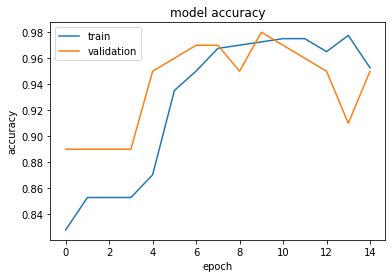

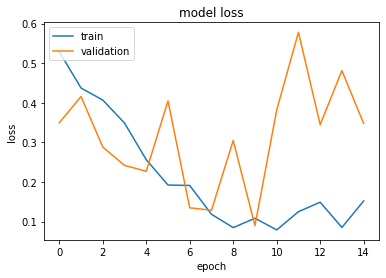

In [18]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
import cv2
import numpy as np
def load(filename):
   np_image = cv2.imread(filename)
   np_image = cv2.resize(np_image, (150, 150))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('bereinigte_Images/hazelnut/bad/3d21d962-bda9-41ef-87a4-89e5b6b50f49.png')
image2=load("bereinigte_Images/hazelnut/good/0c84f678-acf5-44a3-b690-0f4d570646ed.png")
#0: Dosenoeffner   1:Flaschenoeffner   2:Korkenzieher
print("bad")
print (model.predict(image))
print("good")
print(model.predict(image2))

bad
[[1. 0.]]
good
[[1.0000000e+00 4.3420678e-20]]
